In [1]:
# Author: Yuki Rivera
# This notebook contains the implementation of basic transformer using Keras.
# The notebook was used for building and training a basic transformer from scratch.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Sets file paths

In [ ]:
path = "/content/drive/path/to/project/"
results_file_path = "perplexity_score_transformer.txt"
model_path = "basic_transformer_model.keras"
loss_curve_path = "loss_curve_transformer.png"
tokenizer_path = "basic_transformer_tokenizer.pkl"
results_file_path = "results_transformer.txt"

In [21]:
import sys
sys.path.insert(0, path)

### Import the definition of basic_transformer_layers in a separate python file

In [22]:
from basic_transformer_layers import PositionalEncoding, EncoderBlock, DecoderBlock

### Import other libraries

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import pickle
import os
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

### Hyperparameters

In [ ]:
full_data = True
data_size = 1000

# batch_size
batch_size = 64
# number of epochs
num_epochs = 20

# Max sequence length
enc_max_len = 64
dec_max_len = 150

vocab_limit = 15000
# Dimension for token embeddings
embedding_dim = 128
# Number of attention heads
num_heads = 4
# Hidden layer size of feed-forward network
ff_dim = 512
num_layers = 2          # Number of transformer blocks
dropout_rate = 0.3

# size of each head
key_dim = embedding_dim // num_heads
# value to avoid zero division for normalization
eps = 1e-6

# early stopping patience
patience = 3
# threshold for minimum improvement
min_delta = 0.01

# validation_split
validation_ratio = 0.2

# learning rate
alpha = 5e-5 # for small data 3e-4
adam_optimizer = Adam(learning_rate=alpha)

# # label_smoothing
# ls=0.2

### Loads the training dataset

In [26]:
train_df = pd.read_csv("prompt_synopsis_train.csv")

In [27]:
# Samples the data
if not full_data:
    train_df = train_df.sample(n=data_size, random_state=42).reset_index(drop=True)

### Preprocess the data

In [28]:
# Cleans text
def clean_text(text):
    return text.lower().strip().replace('\n', ' ')

for col in ['prompt', 'synopsis']:
    train_df[col] = train_df[col].astype(str).apply(clean_text)

In [ ]:
# Define fixed IDs for special tokens.
PAD_ID = 0
OOV_ID = 1
BOS_ID = 2
EOS_ID = 3

# Number of special tokens we manually reserve IDs for.
NUM_SPECIAL_TOKENS_RESERVED = 4 # (PAD, OOV, BOS, EOS)

# The number of actual content words the tokenizer should learn.
num_words_to_fit = vocab_limit - NUM_SPECIAL_TOKENS_RESERVED

In [30]:
# instantiate a tokenizer (disabling special character filtering)
tokenizer = Tokenizer(num_words=num_words_to_fit, oov_token='<OOV>', filters='')
# the tokenizer builds a single shared vocabulary across both the input and the output
tokenizer.fit_on_texts(train_df['prompt'].tolist() + train_df['synopsis'].tolist())

In [31]:
# Create a new word_index starting from our desired order.
new_word_index = {}
new_index_word = {}

# Assign reserved IDs first
new_word_index["<PAD>"] = PAD_ID
new_index_word[PAD_ID] = "<PAD>"

new_word_index["<OOV>"] = OOV_ID
new_index_word[OOV_ID] = "<OOV>"

new_word_index["<BOS>"] = BOS_ID
new_index_word[BOS_ID] = "<BOS>"

new_word_index["<EOS>"] = EOS_ID
new_index_word[EOS_ID] = "<EOS>"

In [ ]:
# Start assigning IDs from the next available slot after special tokens.
next_available_id = NUM_SPECIAL_TOKENS_RESERVED
content_words_assigned = 0 # Track how many content words we've assigned

for word, original_id in sorted(tokenizer.word_index.items(), key=lambda item: item[1]):
    # Skips words not in the new word index
    if word in new_word_index:
        continue
    # Assign the new ID to the content word
    if content_words_assigned < num_words_to_fit:
        new_word_index[word] = next_available_id
        new_index_word[next_available_id] = word
        next_available_id += 1
        content_words_assigned += 1

    else:
        # Breaks the loop once all required content words have been assigned
        break


tokenizer.word_index = new_word_index
tokenizer.index_word = new_index_word

# Final vocabulary size for the Embedding layer stays the same as the target vocab limit
vocab_size = vocab_limit

### Converts words into token IDs 

In [ ]:
# converts each prompt or synopsis into a list of integers
input_seqs = tokenizer.texts_to_sequences(train_df['prompt'])
output_seqs = tokenizer.texts_to_sequences(train_df['synopsis'])

# Add BOS and EOS tokens to each synopsis sequence 
synopsis_token_ids_augmented = [[BOS_ID] + seq + [EOS_ID] for seq in output_seqs]

### Creates decoder input and target

In [ ]:
# Creates decoder inputs that goes into the decoder during training
decoder_input_ids = [seq[:-1] for seq in synopsis_token_ids_augmented]

# Create decoder targets for loss calculation
decoder_target_ids = [seq[1:] for seq in synopsis_token_ids_augmented]

### Pads sequences

In [35]:
# Encoder input (prompts)
encoder_input_data = pad_sequences(input_seqs, maxlen=enc_max_len, truncating='post', padding='post', value=0)

# Decoder input for training
decoder_input_data = pad_sequences(decoder_input_ids, maxlen=dec_max_len, truncating='post', padding='post', value=0)

# Decoder target for training (needs to be expanded for sparse_categorical_crossentropy)
decoder_target_data = pad_sequences(decoder_target_ids, maxlen=dec_max_len, truncating='post', padding='post', value=0)
decoder_target_data = np.expand_dims(decoder_target_data, axis=-1)

### Saves the tokenizer

In [ ]:
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

### Prepares the training and validation sets

In [37]:
X_enc_train, X_enc_val, X_dec_train, X_dec_val, y_train, y_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=validation_ratio, random_state=42
)

### Create a transformer model (encoder + decoder)

In [ ]:
# This function assembles the encoder and decoder into a complete model.
def build_transformer_model():

    #### Encoder Stack ####

    # Processes input tokens with embeddings, positional encoding, and attention layer.
    encoder_inputs = layers.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    x_enc = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_padding_mask = x_enc._keras_mask
    x_enc = PositionalEncoding(enc_max_len, embedding_dim)(x_enc)
    for _ in range(num_layers):
        x_enc = EncoderBlock(embedding_dim, num_heads, ff_dim, dropout_rate)(x_enc, mask=encoder_padding_mask)
    encoder_outputs = x_enc

    #### Decoder Stack ####

    # Generates output tokens by attending to previous tokens and encoder output
    decoder_inputs = layers.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    x_dec = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_padding_mask = x_dec._keras_mask
    x_dec = PositionalEncoding(dec_max_len, embedding_dim)(x_dec)
    for _ in range(num_layers):
        x_dec = DecoderBlock(embedding_dim, num_heads, ff_dim, dropout_rate)(x_dec, encoder_outputs, decoder_mask=decoder_padding_mask, encoder_mask=encoder_padding_mask)

    # Final output layer to predict the next word.
    outputs = layers.Dense(vocab_size, activation="softmax")(x_dec)

    # Defines the model with inputs and outputs
    model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    return model

### Compiles the Model

In [ ]:
# Builds the model instance.
transformer = build_transformer_model()

# Compiles the model, configuring the optimizer, loss function, and metrics.
transformer.compile(
    optimizer=adam_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Defines callbacks

In [40]:
# Callback for saving the best model
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath= model_path,
    save_best_only=True,
    save_weights_only=False,
    monitor="val_loss",
    verbose=1
)
# callback for early stopping
early_stop_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=patience,
    min_delta=min_delta,
    restore_best_weights=True
)

callbacks = [early_stop_callback, checkpoint_callback]

### Trains the model

In [ ]:
history = transformer.fit(
    [X_enc_train, X_dec_train],
    y_train,
    validation_data=(
        [X_enc_val, X_dec_val],
        y_val),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3987 - loss: 7.6837
Epoch 1: val_loss improved from inf to 4.32344, saving model to basic_transformer_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 152s 105ms/step - accuracy: 0.3987 - loss: 7.6819 - val_accuracy: 0.4317 - val_loss: 4.3234
Epoch 2/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4559 - loss: 4.1079
Epoch 2: val_loss improved from 4.32344 to 3.75364, saving model to basic_transformer_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4559 - loss: 4.1075 - val_accuracy: 0.4933 - val_loss: 3.7536
Epoch 3/20
752/754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4959 - loss: 3.7140
Epoch 3: val_loss improved from 3.75364 to 3.57297, saving model to basic_transformer_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4959 - loss: 3.7139 - val_accuracy: 0.5073 - val_loss: 3.5730
Epoch 4/20
752/754 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5086 - loss: 3.5441
Epo

### Plot the loss curve

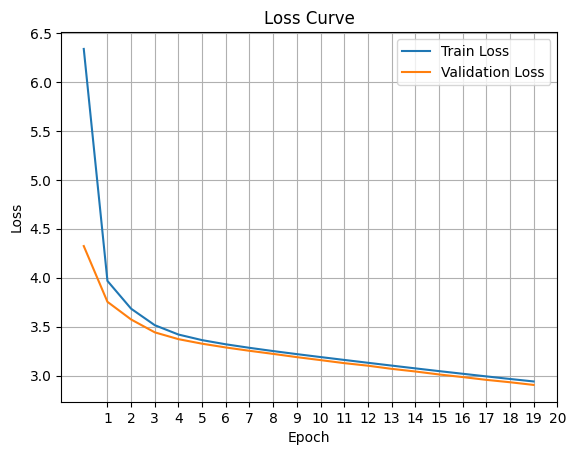

In [42]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig(loss_curve_path, dpi=300, bbox_inches='tight')
plt.xticks(range(1, len(history.history['loss']) + 1))
plt.show()

### Validation Perplexity Calculation

In [ ]:
val_loss, val_accuracy = transformer.evaluate(
    [X_enc_val, X_dec_val], y_val, verbose=0
)
perplexity = np.exp(val_loss)
print(f"Transformer Perplexity: {perplexity:.2f}")

Transformer Perplexity: 18.25


### Saves the hyperparameters used as well as the perplexity value to a text file

In [ ]:
parameters = {'epochs':num_epochs, 'num_layers':num_layers, 'batch_size':batch_size, 'embedding_dim':embedding_dim,
              'num_heads':num_heads, 'ff_dim':ff_dim, 'vocab_limit':vocab_limit, 'learning_rate':alpha,'patience':patience,
              'min_delta':min_delta, 'validation_ratio':validation_ratio, 'dropout':dropout_rate, 'perplexity':perplexity}

results = ''
for key, value in parameters.items():
    results += "{key}: {value}".format(key=key, value=value)
    results += '\n'

with open(results_file_path, 'w') as f:
    f.write(results)

### Quick Generation Check

In [ ]:
# Gets special token IDs 
PAD_ID = tokenizer.word_index.get("<PAD>", 0) 
BOS_ID = tokenizer.word_index["<BOS>"]
EOS_ID = tokenizer.word_index["<EOS>"]

In [ ]:
def generate_synopsis(prompt_text, transformer, tokenizer, enc_max_len, gen_max_len):

    # Preprocesses the input prompt
    prompt_cleaned = clean_text(prompt_text)
    prompt_tokens = tokenizer.texts_to_sequences([prompt_cleaned])
    encoder_input = pad_sequences(prompt_tokens, maxlen=enc_max_len, padding='post', value=PAD_ID)

    encoder_input = tf.constant(encoder_input)
    
    # Initializes the decoder's output sequence 
    decoder_output = tf.constant([[BOS_ID]], dtype=tf.int32)

    # Generates text
    for i in range(gen_max_len):

        predictions = transformer([encoder_input, decoder_output], training=False)

        # Gets the predicted token ID for the very last position in the sequence.
        last_token_logits = predictions[:, -1, :]

        # Masks the OOV logit
        if OOV_ID is not None and 0 <= OOV_ID < last_token_logits.shape[-1]:
            last_token_logits = tf.tensor_scatter_nd_update(
                last_token_logits,
                indices=tf.constant([[0, OOV_ID]], dtype=tf.int32),
                updates=tf.constant([-1e9], dtype=last_token_logits.dtype)
            )


        predicted_id = tf.argmax(last_token_logits, axis=-1, output_type=tf.int32)

        # Checks if the model predicted the End-Of-Sentence token.
        if predicted_id[0] == EOS_ID:
            break

        # Adds the new token to the end of our sequence. 
        decoder_output = tf.concat([decoder_output, predicted_id[:, tf.newaxis]], axis=-1)

    # Converts token IDs to text
    output_tokens = decoder_output.numpy().squeeze().tolist()

    # Removes the initial <BOS> token from the output so it doesn't appear in the text.
    if output_tokens and output_tokens[0] == BOS_ID:
        output_tokens = output_tokens[1:]

    # Uses the tokenizer to convert the list of IDs back into a string.
    generated_text = tokenizer.sequences_to_texts([output_tokens])

    return generated_text[0]

### Generate a synopsis for testing

In [ ]:
test_prompt = 'Write an anime synopsis that matches "Action, Adventure, Comedy and Fantasy".'
generated = generate_synopsis(test_prompt ,transformer, tokenizer, enc_max_len, 50)
print(f"Prompt: {test_prompt}")
print(f"Generated Synopsis: {generated}")